In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

import time

In [ ]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_loader, 0):

            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100*running_correct/len(train_loader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_loader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy of the network on the test images: %d %%' % (test_acc))
    return test_acc

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s] 


Linear(in_features=2048, out_features=1000, bias=True)
Linear(in_features=2048, out_features=196, bias=True)
Using 'cuda:0' to train the Model !
Epoch 1, duration: 148 s, loss: 4.9024, acc: 0.4429
Accuracy of the network on the test images: 15 %
Epoch 2, duration: 129 s, loss: 3.9091, acc: 1.5446
Accuracy of the network on the test images: 27 %
Epoch 3, duration: 129 s, loss: 3.2483, acc: 2.9074
Accuracy of the network on the test images: 40 %
Epoch 4, duration: 130 s, loss: 2.7619, acc: 3.9999
Accuracy of the network on the test images: 51 %
Epoch 5, duration: 129 s, loss: 2.4323, acc: 4.9664
Accuracy of the network on the test images: 59 %
Epoch 6, duration: 129 s, loss: 2.1221, acc: 5.8304
Accuracy of the network on the test images: 63 %
Epoch 7, duration: 129 s, loss: 1.9705, acc: 6.2174
Accuracy of the network on the test images: 69 %
Epoch 8, duration: 129 s, loss: 1.4592, acc: 8.1318
Accuracy of the network on the test images: 79 %
Epoch 9, duration: 129 s, loss: 1.2514, acc: 8.

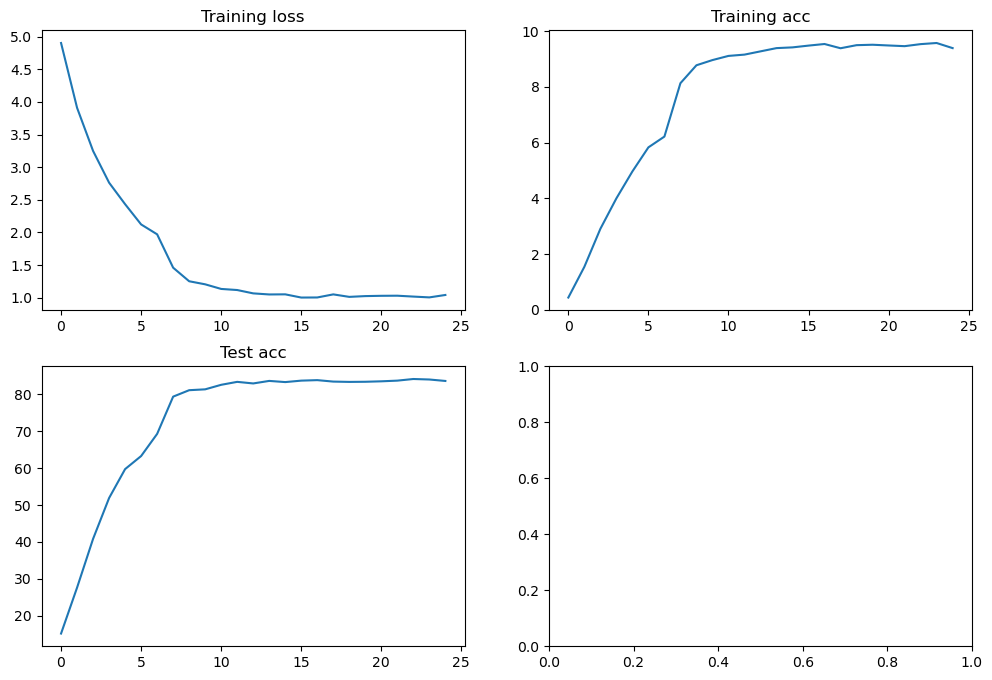

In [1]:
train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225]
        )
    ])

train_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train',
        transform=train_transforms
    )
val_dataset = datasets.ImageFolder(
        root='/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/test',
        transform=val_transforms
    )

train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )
val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=2
    )

model = models.resnet50(pretrained=True)
print(model.fc)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)

print(model.fc)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using '{device}' to train the Model !")

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

model, training_losses, training_accs, test_accs = train_model(model, criterion, optimizer, lrscheduler, n_epochs=25)
    
torch.save(model.state_dict(), "./trainedModelFinal.pt")
    
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")
axarr[1, 0].plot(test_accs)
axarr[1, 0].set_title("Test acc")
    
model.eval()

In [ ]:
torch.save(model.state_dict(), "./trainedModelFinal_new.pt")
torch.save(model.state_dict(), 'resnet50_car_classification_new.h5')